# Matrix Analysis Notebook

This notebook is designed to analyze and visualize the differences between two matrices: 
1. The original weight matrix from data (W)
2. A randomly permuted matrix with the same sparsity (W_random)

We'll perform the following analyses:
- SVD distribution comparison
- Spectrum diameter of eigenvalues
- Degree distribution and analysis
- Graph metrics visualization using networkx

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import svd, eig
from connectome import load_drosophila_matrix

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
W = load_drosophila_matrix('../data/signed_connectivity_matrix.csv', signed=True)
print(f"Original matrix shape: {W.shape}")
print(f"Nonzero elements: {np.count_nonzero(W)}")
print(f"Sparsity: {np.count_nonzero(W) / (W.shape[0] * W.shape[1]) * 100:.2f}%")

Original matrix shape: (2952, 2952)
Nonzero elements: 63545
Sparsity: 0.73%


In [3]:
def generate_random_matrix(base_matrix):
    """Generate a random matrix with the same sparsity pattern as the base matrix"""
    nonzero_vals = base_matrix[base_matrix != 0].astype(np.float32)
    np.random.shuffle(nonzero_vals)
    
    non_zero_count = len(nonzero_vals)
    idx = np.random.choice(base_matrix.size, non_zero_count, replace=False)
    arr_np = np.zeros_like(base_matrix, dtype=np.float32)
    
    arr_np_flat = arr_np.flatten()
    arr_np_flat[idx] = nonzero_vals
    arr_np = arr_np_flat.reshape(base_matrix.shape)
    
    return arr_np

# Generate the permuted matrix
np.random.seed(42)  # For reproducibility
W_random = generate_random_matrix(W)
print(f"Random matrix shape: {W_random.shape}")
print(f"Nonzero elements: {np.count_nonzero(W_random)}")
print(f"Sparsity: {np.count_nonzero(W_random) / (W_random.shape[0] * W_random.shape[1]) * 100:.2f}%")

Random matrix shape: (2952, 2952)
Nonzero elements: 63545
Sparsity: 0.73%


## 1. SVD Distribution Analysis

Singular Value Decomposition (SVD) helps us understand the intrinsic dimensionality and structure of matrices.

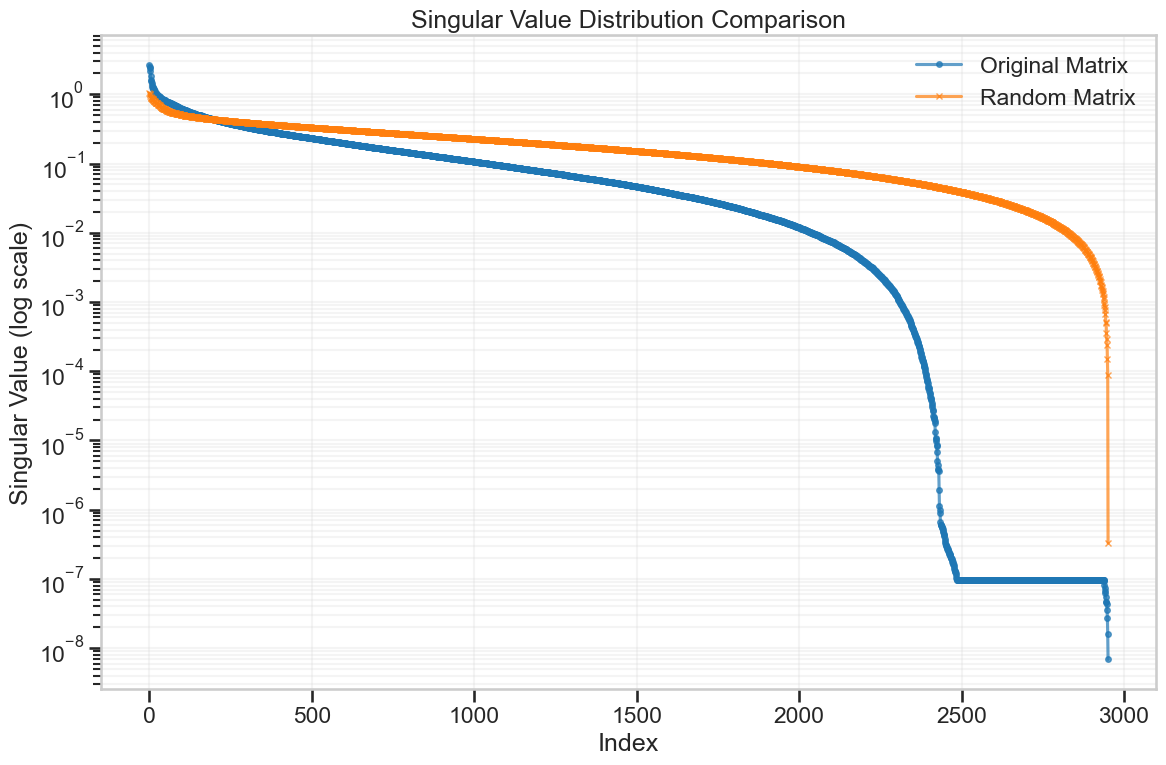

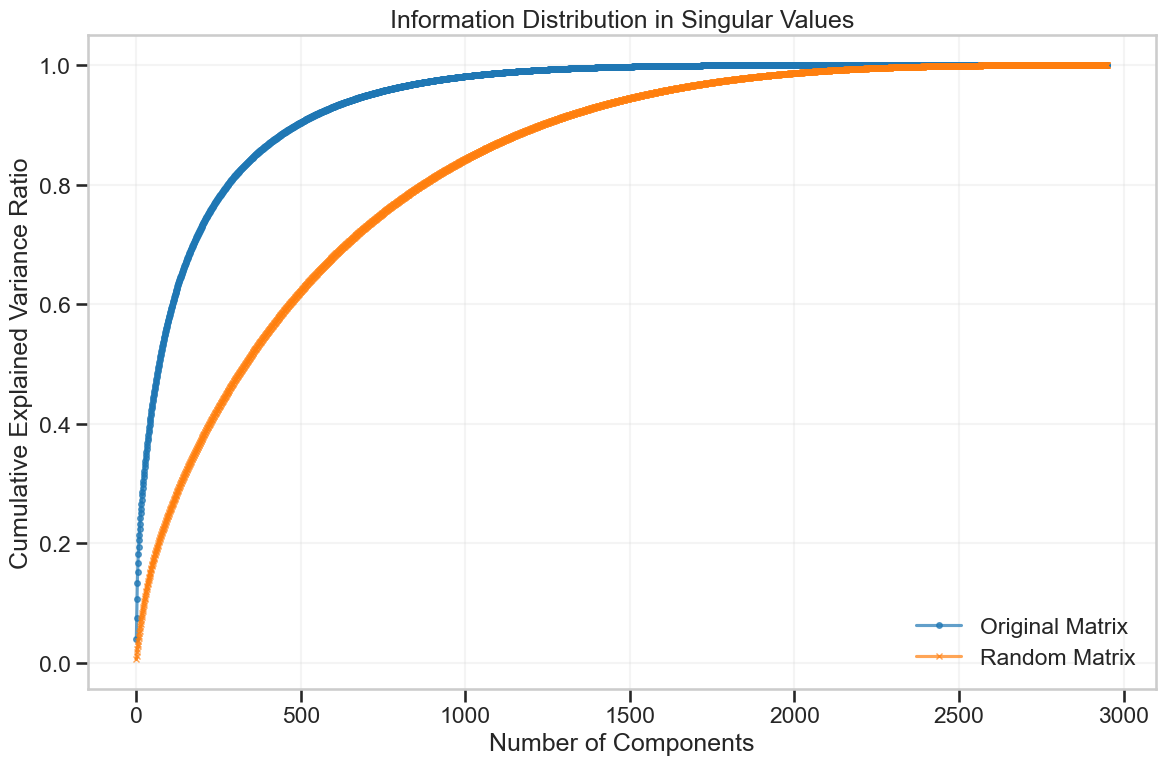

Original matrix - Top 10 singular values: [2.6457145 2.4749322 2.3610926 2.1643903 1.8089689 1.621081  1.5763491
 1.4416937 1.3730106 1.289859 ]
Random matrix - Top 10 singular values: [1.042732   1.015038   1.0036659  0.94027036 0.9155318  0.8942925
 0.87553376 0.872742   0.8627836  0.8599937 ]
Original matrix - Top 10% components explain 81.17% of variance
Random matrix - Top 10% components explain 46.92% of variance


In [4]:
# Compute SVD for both matrices
U, s, Vh = svd(W, full_matrices=False)
U_random, s_random, Vh_random = svd(W_random, full_matrices=False)

plt.figure(figsize=(12, 8))

# Plot on log scale for better visibility
plt.semilogy(s, 'o-', markersize=4, alpha=0.7, label='Original Matrix')
plt.semilogy(s_random, 'x-', markersize=4, alpha=0.7, label='Random Matrix')

plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlabel('Index')
plt.ylabel('Singular Value (log scale)')
plt.title('Singular Value Distribution Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(s**2) / np.sum(s**2)
cumulative_variance_ratio_random = np.cumsum(s_random**2) / np.sum(s_random**2)

plt.figure(figsize=(12, 8))
plt.plot(cumulative_variance_ratio, 'o-', markersize=4, alpha=0.7, label='Original Matrix')
plt.plot(cumulative_variance_ratio_random, 'x-', markersize=4, alpha=0.7, label='Random Matrix')

plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Information Distribution in Singular Values')
plt.legend()
plt.tight_layout()
plt.show()

# Print key SVD statistics
print(f"Original matrix - Top 10 singular values: {s[:10]}")
print(f"Random matrix - Top 10 singular values: {s_random[:10]}")
print(f"Original matrix - Top 10% components explain {cumulative_variance_ratio[int(len(s)*0.1)]:.2%} of variance")
print(f"Random matrix - Top 10% components explain {cumulative_variance_ratio_random[int(len(s_random)*0.1)]:.2%} of variance")

## 2. Spectrum Diameter (Eigenvalue Analysis)

The eigenvalue spectrum provides insights into the dynamics of the system represented by the matrix.

Original matrix - Spectral radius: 0.3912
Random matrix - Spectral radius: 0.3960
Original matrix - Spectral diameter: 0.7792
Random matrix - Spectral diameter: 0.6339


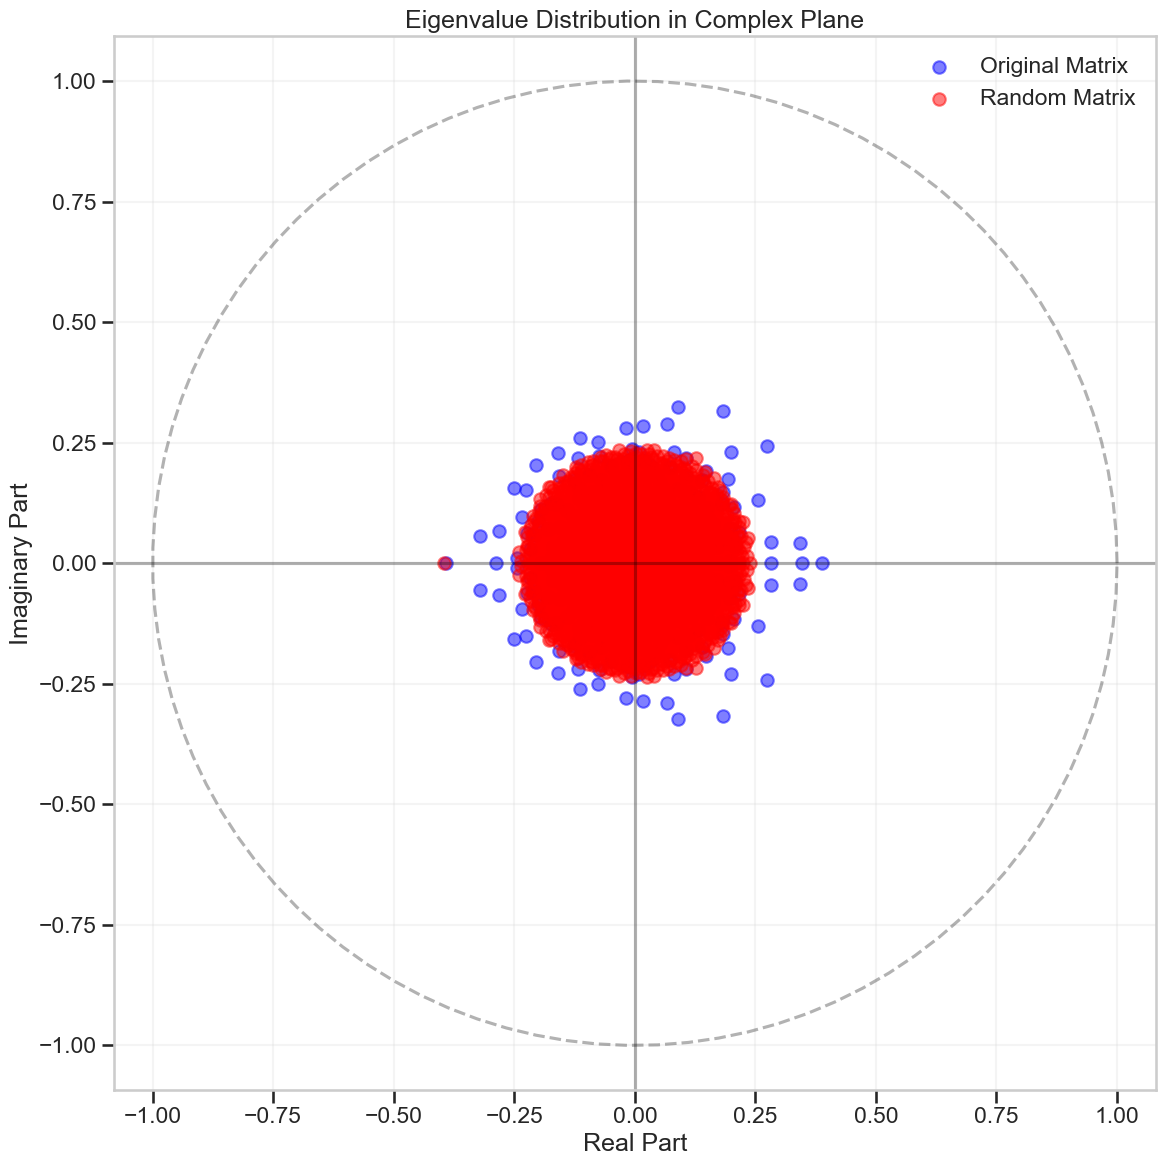

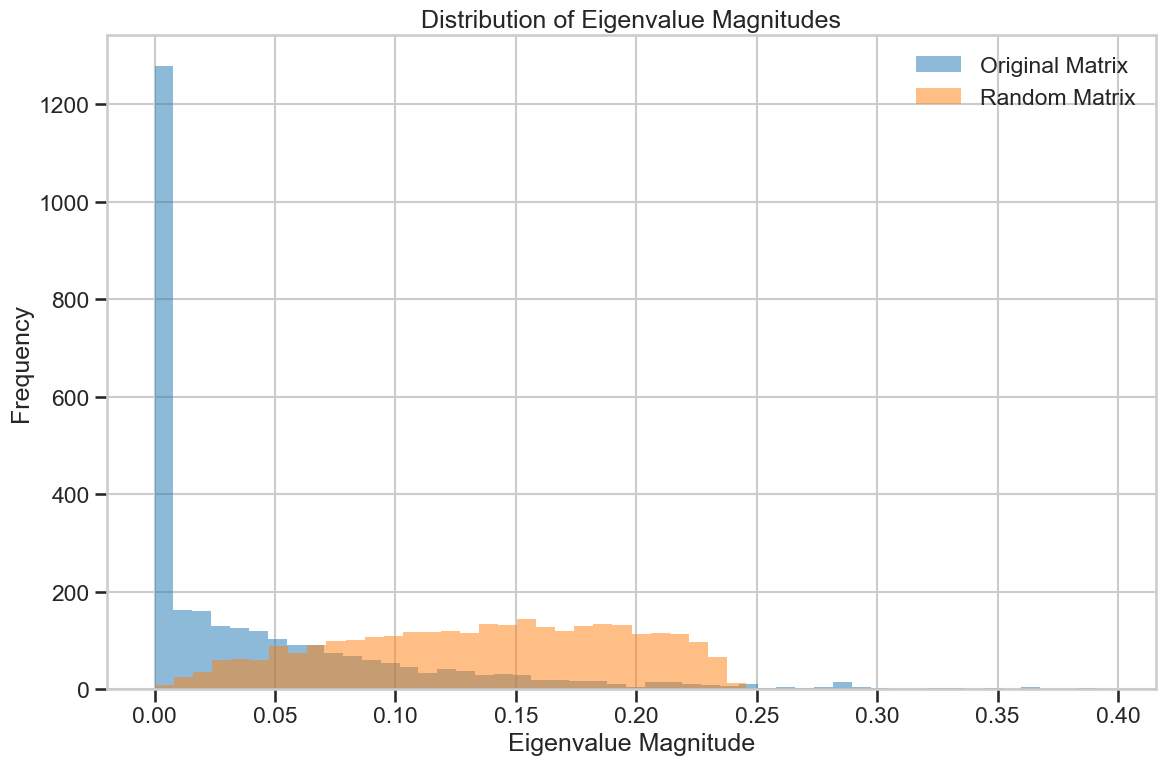

In [5]:
# Calculate eigenvalues for both matrices
eigenvalues_W = eig(W)[0]
eigenvalues_W_random = eig(W_random)[0]

# Calculate spectral radius (maximum absolute eigenvalue)
spectral_radius_W = np.max(np.abs(eigenvalues_W))
spectral_radius_W_random = np.max(np.abs(eigenvalues_W_random))

# Calculate spectral diameter (difference between max and min eigenvalues)
spectral_diameter_W = np.max(np.real(eigenvalues_W)) - np.min(np.real(eigenvalues_W))
spectral_diameter_W_random = np.max(np.real(eigenvalues_W_random)) - np.min(np.real(eigenvalues_W_random))

print(f"Original matrix - Spectral radius: {spectral_radius_W:.4f}")
print(f"Random matrix - Spectral radius: {spectral_radius_W_random:.4f}")
print(f"Original matrix - Spectral diameter: {spectral_diameter_W:.4f}")
print(f"Random matrix - Spectral diameter: {spectral_diameter_W_random:.4f}")

# Visualize eigenvalues in the complex plane
plt.figure(figsize=(12, 12))
plt.scatter(np.real(eigenvalues_W), np.imag(eigenvalues_W), color='blue', alpha=0.5, label='Original Matrix')
plt.scatter(np.real(eigenvalues_W_random), np.imag(eigenvalues_W_random), color='red', alpha=0.5, label='Random Matrix')

# Add a unit circle as reference
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.3)

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.2)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Eigenvalue Distribution in Complex Plane')
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

# Plot eigenvalue magnitude distribution (histograms)
plt.figure(figsize=(12, 8))
plt.hist(np.abs(eigenvalues_W), bins=50, alpha=0.5, label='Original Matrix')
plt.hist(np.abs(eigenvalues_W_random), bins=50, alpha=0.5, label='Random Matrix')
plt.xlabel('Eigenvalue Magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of Eigenvalue Magnitudes')
plt.legend()
plt.tight_layout()
plt.show()

## 3. Degree Distribution Analysis

Treating the matrices as adjacency matrices of weighted graphs, we analyze the in-degree and out-degree distributions.

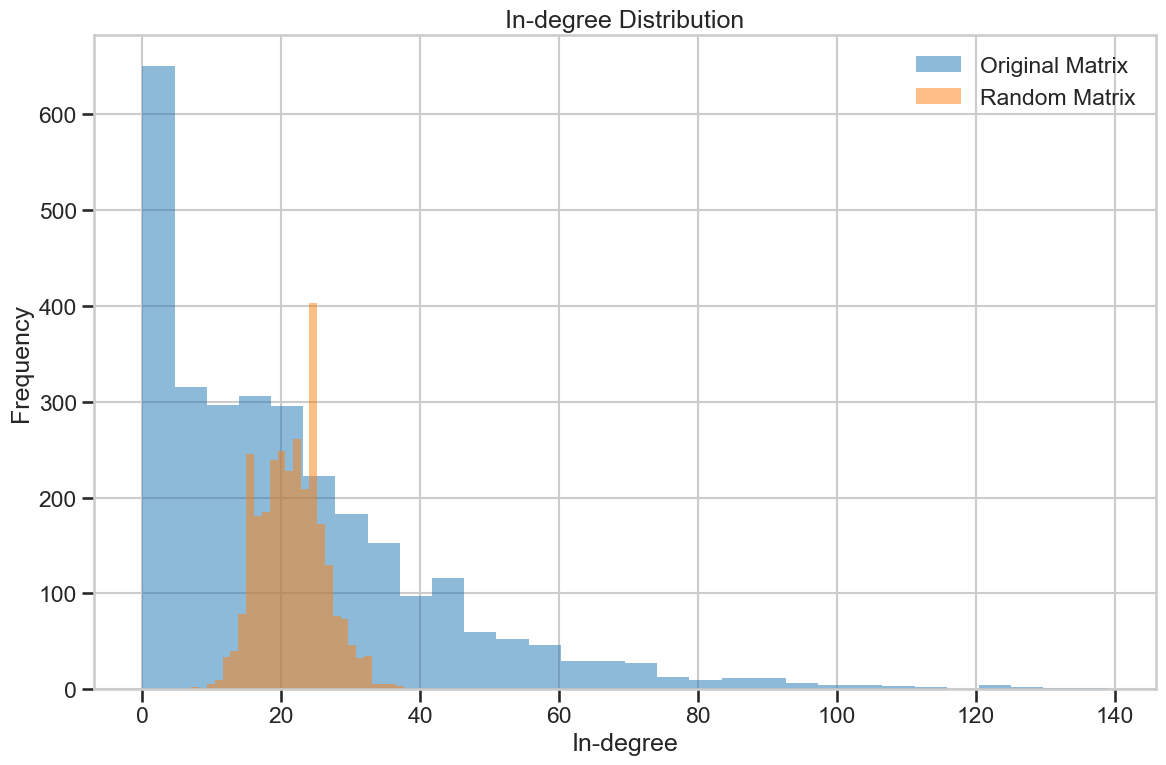

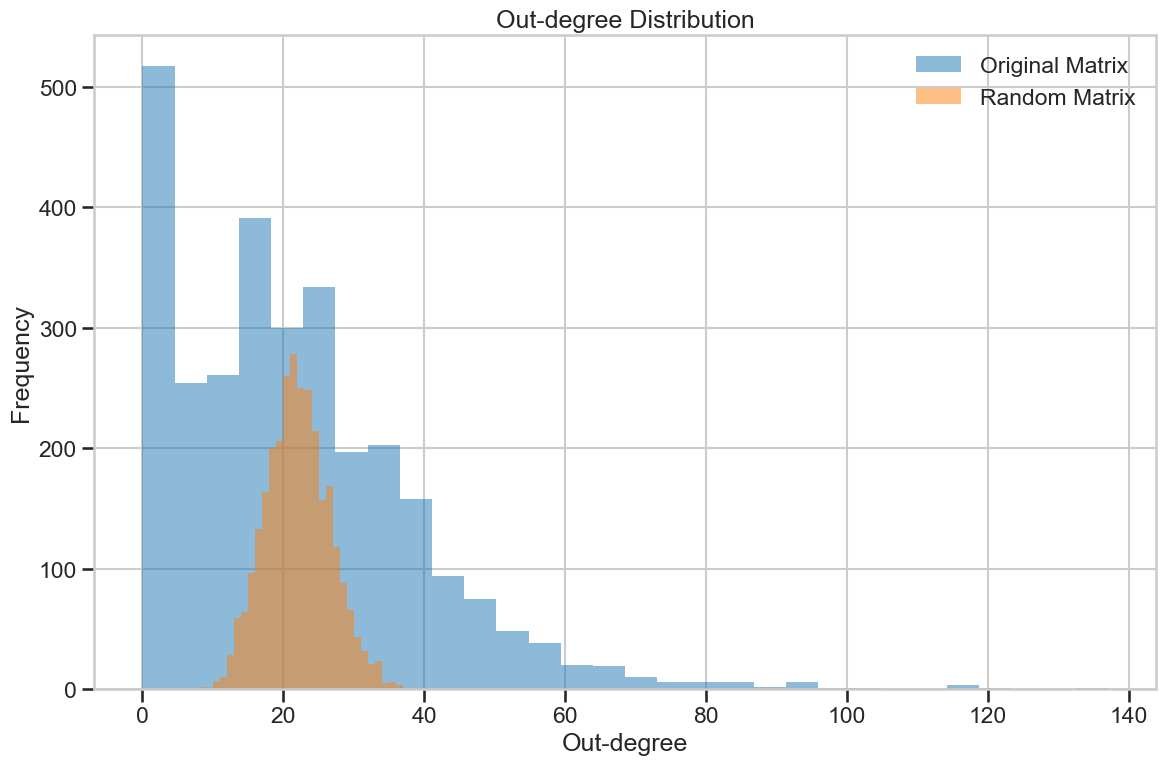

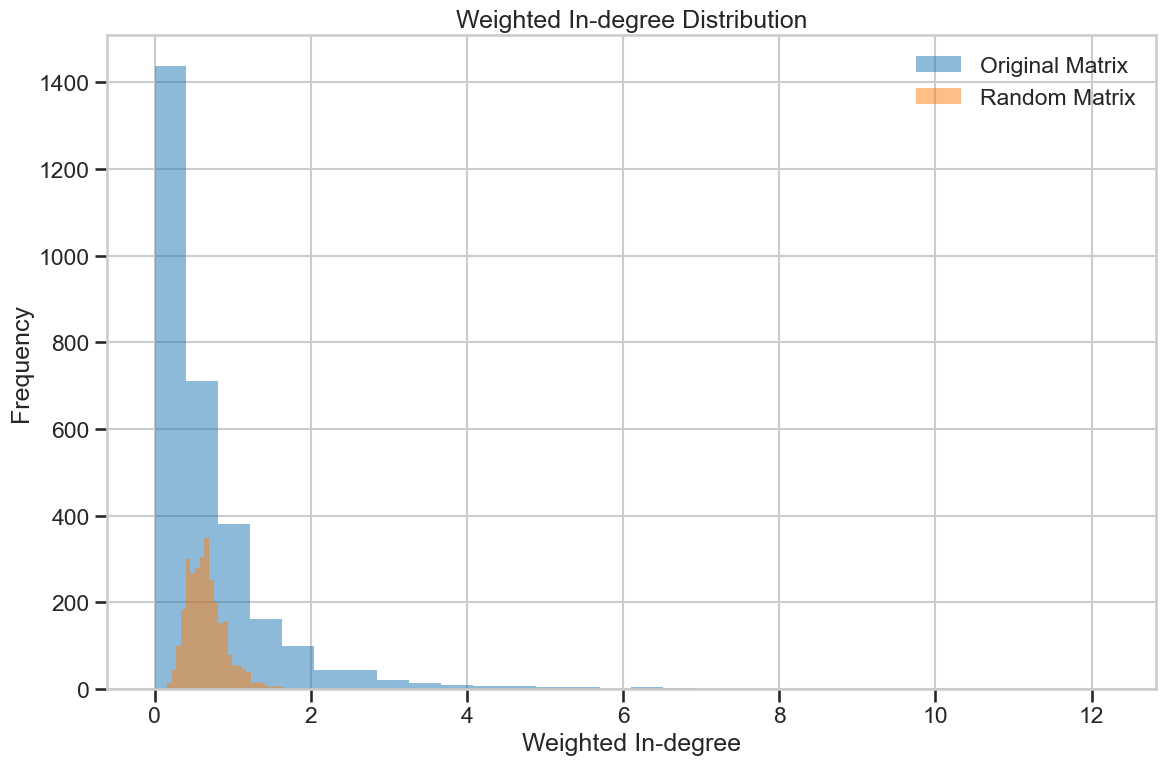

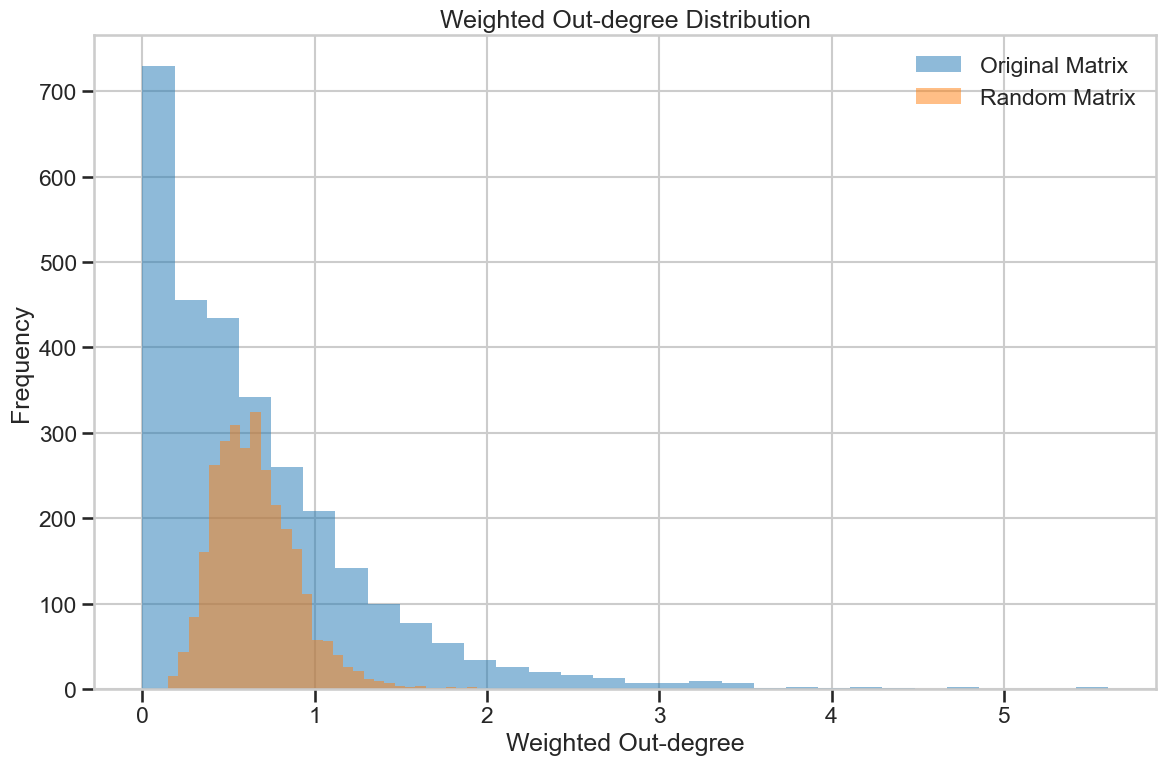

Original matrix - Average in-degree: 21.53, Std: 20.56
Random matrix - Average in-degree: 21.53, Std: 4.60
Original matrix - Average out-degree: 21.53, Std: 17.01
Random matrix - Average out-degree: 21.53, Std: 4.55


In [6]:
# Calculate in-degree and out-degree for both matrices
in_degree_W = np.sum(W != 0, axis=0)
out_degree_W = np.sum(W != 0, axis=1)
in_degree_W_random = np.sum(W_random != 0, axis=0)
out_degree_W_random = np.sum(W_random != 0, axis=1)

# Also calculate weighted degrees (sum of weights)
weighted_in_degree_W = np.sum(np.abs(W), axis=0)
weighted_out_degree_W = np.sum(np.abs(W), axis=1)
weighted_in_degree_W_random = np.sum(np.abs(W_random), axis=0)
weighted_out_degree_W_random = np.sum(np.abs(W_random), axis=1)

# Plot in-degree distributions
plt.figure(figsize=(12, 8))
plt.hist(in_degree_W, bins=30, alpha=0.5, label='Original Matrix')
plt.hist(in_degree_W_random, bins=30, alpha=0.5, label='Random Matrix')
plt.xlabel('In-degree')
plt.ylabel('Frequency')
plt.title('In-degree Distribution')
plt.legend()
plt.tight_layout()
plt.show()

# Plot out-degree distributions
plt.figure(figsize=(12, 8))
plt.hist(out_degree_W, bins=30, alpha=0.5, label='Original Matrix')
plt.hist(out_degree_W_random, bins=30, alpha=0.5, label='Random Matrix')
plt.xlabel('Out-degree')
plt.ylabel('Frequency')
plt.title('Out-degree Distribution')
plt.legend()
plt.tight_layout()
plt.show()

# Plot weighted in-degree distributions
plt.figure(figsize=(12, 8))
plt.hist(weighted_in_degree_W, bins=30, alpha=0.5, label='Original Matrix')
plt.hist(weighted_in_degree_W_random, bins=30, alpha=0.5, label='Random Matrix')
plt.xlabel('Weighted In-degree')
plt.ylabel('Frequency')
plt.title('Weighted In-degree Distribution')
plt.legend()
plt.tight_layout()
plt.show()

# Plot weighted out-degree distributions
plt.figure(figsize=(12, 8))
plt.hist(weighted_out_degree_W, bins=30, alpha=0.5, label='Original Matrix')
plt.hist(weighted_out_degree_W_random, bins=30, alpha=0.5, label='Random Matrix')
plt.xlabel('Weighted Out-degree')
plt.ylabel('Frequency')
plt.title('Weighted Out-degree Distribution')
plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics for degrees
print(f"Original matrix - Average in-degree: {np.mean(in_degree_W):.2f}, Std: {np.std(in_degree_W):.2f}")
print(f"Random matrix - Average in-degree: {np.mean(in_degree_W_random):.2f}, Std: {np.std(in_degree_W_random):.2f}")
print(f"Original matrix - Average out-degree: {np.mean(out_degree_W):.2f}, Std: {np.std(out_degree_W):.2f}")
print(f"Random matrix - Average out-degree: {np.mean(out_degree_W_random):.2f}, Std: {np.std(out_degree_W_random):.2f}")